In [116]:
import openseespy.opensees as ops
import numpy as np
import opsvis as ovs
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'notebook', 'grid'])

### Response Spectra
A plot of the peak value of a response quantity as a function of the natural vibration period $T_n$ of the system, or a related parameter such as circular frequency $ω_n$ or cyclic frequency $f_n$, is called the response spectrum for that quantity. Each such plot is for SDF systems having a fixed damping ratio $\xi$ , and several such plots for different values of $\xi$ are included to cover the range of damping values encountered in actual structures. 

#### Units for this code
1. mass = kg 
2. force = kN
3. Displacement = cm
4. time = s

In [6]:
# ground motion
val = np.loadtxt("ElCentro.txt")
dt = 0.02
dtAnalysis = 0.005
TmaxAnalysis = 30
nStep = int(TmaxAnalysis/dtAnalysis)

In [80]:
def getModel(uniqueID:int, T:float):
    uniqueID = int(uniqueID)
    ops.node(uniqueID+1, uniqueID)
    ops.node(uniqueID+2, uniqueID)
    ops.fix(uniqueID+1, uniqueID)
    
    xi = 0.02
    w = 2*np.pi / T
    
    m = 45594
    k = w**2 * m
    c = 2*m*w*xi
    
    ops.mass(uniqueID+2, m)
    
    parallelMat = uniqueID+3
    ops.uniaxialMaterial('Elastic', uniqueID+1, k) #left stiffness param
    ops.uniaxialMaterial('Viscous', uniqueID+2, c, 1) #left damping param
    ops.uniaxialMaterial('Parallel', parallelMat, *[uniqueID+1, uniqueID+2]) #left combined

    ops.element('zeroLength', uniqueID+1, *[uniqueID+1,uniqueID+2], '-mat', parallelMat, '-dir', 1) #element


In [56]:
def applyGroundMotion():
    gmTS = 1
    GM_dirn = 1
    GM_fact = 9.81
    ops.timeSeries("Path", gmTS, '-dt', dt, '-values', *val)
    ops.pattern('UniformExcitation', 300, GM_dirn, '-accel', gmTS, '-fact', GM_fact)

    ops.constraints("Transformation")
    ops.numberer("Plain")
    ops.system("ProfileSPD")
    tol = 1.e-8
    maxNumIter = 50
    ops.test("EnergyIncr", tol, maxNumIter)
    ops.algorithm("ModifiedNewton")
    ops.integrator("Newmark", .5, .25)
    ops.analysis("Transient")

def getResponse(nodeList):

    to_return = {str(node):[] for node in nodeList}

    for i in range(nStep):
        ops.analyze(1, dtAnalysis)
        for node in nodeList:
            to_return[str(node)].append(ops.nodeDisp(int(node), 1)*100)   #in cm

    return to_return

def getMaxResp(responseDict):
    return {k:abs(max(responseDict[k], key=abs)) for (k,v) in responseDict.items()}
        
    

# Deformation Response Spectrum

### 1. Verification from A.K. Chopra
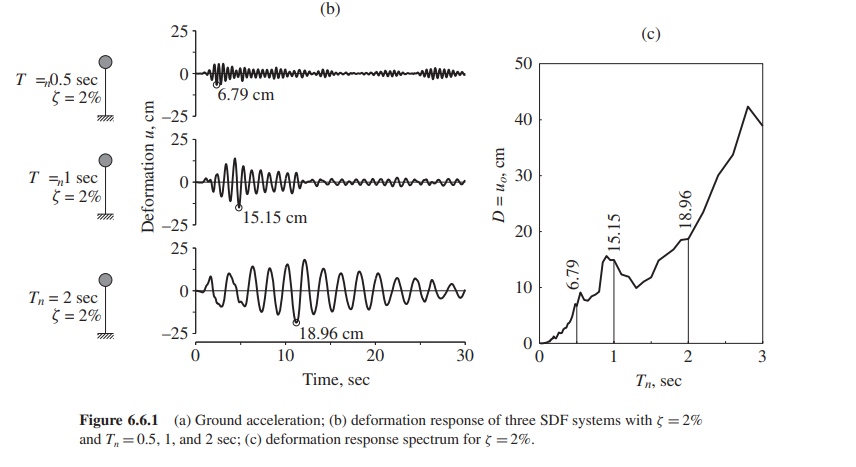

In [94]:
ops.wipe()
ops.model('Basic', '-ndm', 1, '-ndf', 1)

### first lets build our 3 models with following time periods
modelID = [10, 20, 30]
TimePeriod = [.5, 1, 2]
nodeTimeDict = {ID+2:T for (ID,T) in zip(modelID, TimePeriod)}  #to keep track of free node that we are interested in

In [95]:
#now build model
for ID,T in zip(modelID, TimePeriod):
    getModel(ID, T)

applyGroundMotion()

In [96]:
response = getResponse(nodeTimeDict.keys())

In [97]:
maxResponse = getMaxResp(response)

In [98]:
maxResponse

{'12': 6.824285269586615, '22': 15.153675456210697, '32': 18.970498117584523}

Hence the maximum responses are verified for our models

## 2. Plotting of Deformation Response Spectra from Time Period 0 to 3s
We must skip 0 time period, as it will lead to infinite frequency

In [200]:
ops.wipe()
ops.model('Basic', '-ndm', 1, '-ndf', 1)

modelID = np.arange(10, 400, 4) # this will create models with time period varying from 0 to 3s
TimePeriod = np.linspace(0.05, 3, len(modelID))

nodeTimeDict = {ID+2:T for (ID,T) in zip(modelID, TimePeriod)}  #to keep track of free node that we are interested in

In [201]:
#now build model
for ID,T in zip(modelID, TimePeriod):
    getModel(ID, T)

applyGroundMotion()

In [202]:
%%time
response = getResponse(nodeTimeDict.keys())
maxResponse = getMaxResp(response)

CPU times: total: 1.92 s
Wall time: 1.93 s


Text(0, 0.5, 'D = $u_0$, cm')

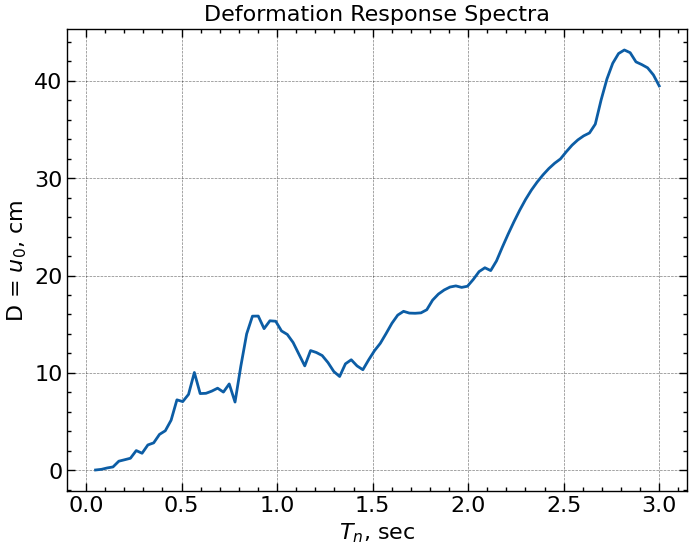

In [203]:
plt.plot(TimePeriod, maxResponse.values())
plt.title("Deformation Response Spectra")
plt.xlabel(r"$T_n$, sec")
plt.ylabel(r"D = $u_0$, cm")

In [204]:
PseudoVelocityResponseSpectrum = np.array(list(maxResponse.values()))*2*np.pi/TimePeriod

PseudoAccelResponseSpectrum = np.array(list(maxResponse.values()))*(2*np.pi/TimePeriod)**2

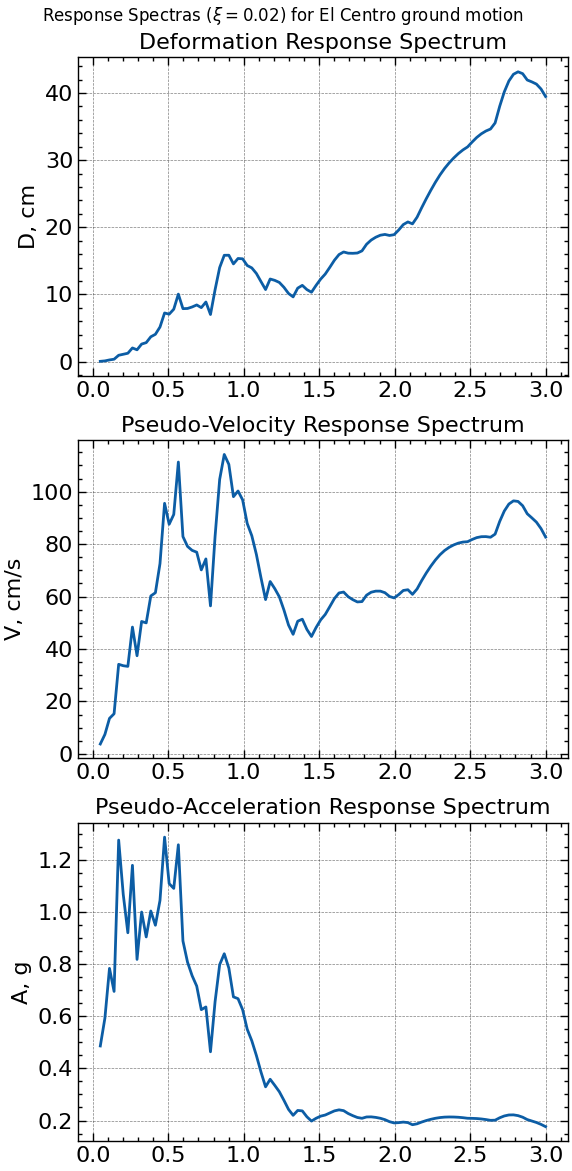

In [208]:
fig, ax = plt.subplots(3,1, figsize=(6,12), tight_layout = True)

ax[0].plot(TimePeriod, maxResponse.values())
ax[0].set_ylabel("D, cm")
ax[0].set_title("Deformation Response Spectrum")
ax[1].plot(TimePeriod, PseudoVelocityResponseSpectrum)
ax[1].set_title("Pseudo-Velocity Response Spectrum")
ax[1].set_ylabel("V, cm/s")
ax[2].plot(TimePeriod, PseudoAccelResponseSpectrum/981) #to convert into pga 981 cm/s^2
ax[2].set_title("Pseudo-Acceleration Response Spectrum")
ax[2].set_ylabel("A, g")
plt.suptitle(r"Response Spectras $(\xi=0.02)$ for El Centro ground motion")
plt.show()